In [8]:
# -*- coding: utf-8 -*-
# @Time    : 2022-5-13 10:00
# @Author  : zhangbowen

In [3]:
import pandas as pd
import numpy as np
import datetime
from scipy import stats
import random
from utils.utils import normalization, standardization
import warnings
warnings.filterwarnings('ignore')

In [10]:
########## read row data ##########
data_path = r'data/raw_utf-8.csv' 
df = pd.read_csv(data_path, encoding='utf-8', low_memory=False) # for ignore DtypeWarningb
# list column names
column_names = df.columns.values.tolist()
# dataframe --> ndarray --> list
features = []
for i in range(len(column_names)):
    features.append(np.array(df[column_names[i]]))

In [11]:
########## label selection ##########
# feature 47: 現在_退職・休職区分 (0: 在職中, 1: 休職, 2: 退職, 3: その他; 82559 + 640 + 6184 = 89383)  
# feature 48: 現在_退職日
# feature 55: 回答日

##### 退職
date_turnover_all = features[48][features[47]==2]
date_answer_all = features[55][features[47]==2]
num_turnover = sum(features[47]==2) # 6184

intervals = []
for i in range(num_turnover):
    # answer date
    year_answer = int(date_answer_all[i][0:4])
    month_answer = int(date_answer_all[i][5:7])
    day_answer = int(date_answer_all[i][8:10])
    date_answer = datetime.datetime(year_answer, month_answer, day_answer) 
    # turnover date
    year_turnover = int(date_turnover_all[i][0:4])
    month_turnover = int(date_turnover_all[i][5:7])
    day_turnover = int(date_turnover_all[i][8:10])
    date_turnover = datetime.datetime(year_turnover, month_turnover, day_turnover) 
    # intervals
    intervals.append((date_turnover - date_answer).days)
    
# mode_intervals = stats.mode(intervals)[0][0]

id_label_1 = []
for i, interval in enumerate(intervals):
    if interval >=120 and interval <=150: # 346
        id_label_1.append(i)

label_1 = features[47][features[47]==2][id_label_1]

##### 在職中
num_label_0 = len(label_1) ########## 把在职设为与离职数量346相等 ##########
# num_label_0 = 82559 ########## 自定义在职数量(maximum: 82559) ##########

tmp = [i for i in range(len(features[47][features[47]==0]))] # [0, 1, ..., 82557, 82558] 在職中: 82559
id_label_0 = random.sample(tmp, num_label_0) # [0, 1, ..., 82557, 82558]中的346个
label_0 = features[47][features[47]==0][id_label_0]

In [12]:
########## label encoding ##########
label_0[label_0==0] = 0 # 在職中
label_1[label_1==2] = 1 # 離職

new_label = np.hstack([label_0, label_1]) # num(在職) + 346(退職)

In [13]:
########## features selection (method 1) (19 ojective + 17 subjective = 36) ##########
flag_customize = False
## ojective features (19)
# 3: '業種大分類名称',
# 5: '業種中分類名称',
# 7: '性別',
# 8: '血液型',
# 9: '誕生年',
# 11: '入社年',
# 13: '学歴名称',
# 15: '雇用形態名称',
# 17: '勤務形態名称',
# 19: '職種名称',
# 21: '個人年収名称',
# 23: '世帯年収名称',
# 25: '結婚名称',
# 27: '家族と同居名称',
# 31: '介護名称',
# 33: '怪我／病気名称',
# 35: '精神科受診歴名称',
# 37: '入社形態名称',
# 39: '勤務場所名称',

## subjective features (17)
# B類質問（58-212）
# 58: 'B-1-2(非常にたくさんの仕事をしなければならない)',　 疲れ
# 64: 'B-7-27(からだを大変よく使う仕事だ)',　 体
# 65: 'B-8-29(自分のペースで仕事ができる)',　 自分のやり方と合うか
# 68: 'B-11-44(自分の技能や知識を仕事で使うことが少ない)',　 自分の価値
# 71: 'B-14-53(私の職場の雰囲気は友好的である)',　 職場の雰囲気
# 72: 'B-15-60(私の職場の作業環境（騒音、照明、温度、換気など）はよくない)',　 職場の施設
# 74: 'B-17-65(働きがいのある仕事だ)',　 仕事の価値
# 76: 'B-19-75(元気がいっぱいだ)',　 やる気があるか
# 78: 'B-21-81(怒りを感じる)',　 怒る
# 103: 'B-46-182(よく眠れない)',　 不眠症
# 119: 'B-62-245(自分の仕事に見合う給料やボーナスをもらっている)',　 給料に満足か
# 134: 'B-77-308(職場で自分がいじめにあっている (セクハラ、パワハラを含む))',　 職場のパワハラ
# 147: 'B-180-843(職場で自分以外でいじめにあっている人がいる(セクハラ、パワハラを含む))',　 職場以外のパワハラ
# 159: 'B-192-888(現在の職場で働くことを友人や家族に勧めたい)',　 潜在的に離職したくない
# 160: 'B-193-893(職場は衛生的である)',　 職場の綺麗さ
# 197: 'B-216-999(毎日の通勤でストレスを感じる)',　 通勤距離
# 198: 'B-217-1000(1ヶ月の平均的な残業時間はどれくらいか教えて下さい)',　 残業

########## 19 ojective + 17 subjective = 36 ##########
feature_ids = [3, 5, 7, 8, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 31, 33, 35, 37, 39, 58, 64, 65, 68, 71, 72, 74, 76, 78, 103, 119, 134, 147, 159, 160, 197, 198]

new_features = []
for row, feature_id in enumerate(feature_ids): # numbers of feature (e.g. 36)
    feature = np.hstack([features[feature_id][features[47]==0][id_label_0], features[feature_id][features[47]==2][id_label_1]]) # num(在職) + 346(退職)
    new_features.append(feature)

In [14]:
########## features encoding (method 1) (19 ojective + 17 subjective = 36) ##########
########## 19 ojective (miss, unknown)

# 3: '業種大分類名称', カテゴリー：frequency encoding
for category in set(new_features[0]):
    if not (category is np.nan):
        freq = sum(new_features[0]==category) / len(new_features[0])
        new_features[0][new_features[0]==category] = freq

new_features[0] = new_features[0].astype(np.float32)

# 5: '業種中分類名称', カテゴリー：frequency encoding
for category in set(new_features[1]):
    if not (category is np.nan):
        freq = sum(new_features[1]==category) / len(new_features[1])
        new_features[1][new_features[1]==category] = freq

new_features[1] = new_features[1].astype(np.float32)

# 7: '性別', カテゴリー：frequency encoding
new_features[2] = new_features[2].astype(np.float32)

for category in set(new_features[2]):
    if not (category is np.nan):
        freq = sum(new_features[2]==category) / len(new_features[2])
        new_features[2][new_features[2]==category] = freq
        
# 8: '血液型', カテゴリー：frequency encoding
mode = stats.mode(new_features[3])[0][0] # mode
new_features[3][new_features[3]=='z'] = np.array([mode]*len(new_features[3][new_features[3]=='z'])) # unknow

freqs = []
for category in set(new_features[3]):
    if not (category is np.nan):
        freq = sum(new_features[3]==category) / len(new_features[3])
        new_features[3][new_features[3]==category] = freq
        freqs.append(freq)

new_features[3] = new_features[3].astype(np.float32)

freqs = np.array(freqs)
new_features[3][np.isnan(new_features[3])]  = np.array([freqs.max()]*sum(np.isnan(new_features[3]))) # nan

# 9: '誕生年', 数値
new_features[4] = pd.DataFrame(new_features[4]) # ndarray --> pandas
mean = new_features[4][new_features[4].notnull()].mean()
new_features[4] = new_features[4].fillna(mean) # nan
new_features[4] = np.array(new_features[4]).reshape(-1) # pandas --> ndarray

new_features[4] = new_features[4].astype(np.float32)

# 11: '入社年', 数値
new_features[5] = new_features[5].astype(np.float32)

# 13: '学歴名称', カテゴリー：frequency encoding
freqs = []
for category in set(new_features[6]):
    if not (category is np.nan):
        freq = sum(new_features[6]==category) / len(new_features[6])
        new_features[6][new_features[6]==category] = freq
        freqs.append(freq)

new_features[6] = new_features[6].astype(np.float32)

freqs = np.array(freqs)
new_features[6][np.isnan(new_features[6])]  = np.array([freqs.max()]*sum(np.isnan(new_features[6]))) # nan

# 15: '雇用形態名称', カテゴリー：frequency encoding
mode = stats.mode(new_features[7])[0][0] # mode
new_features[7][new_features[7]=='未入力'] = np.array([mode]*len(new_features[7][new_features[7]=='未入力'])) # unknow

freqs = []
for category in set(new_features[7]):
    if not (category is np.nan):
        freq = sum(new_features[7]==category) / len(new_features[7])
        new_features[7][new_features[7]==category] = freq
        freqs.append(freq)

new_features[7] = new_features[7].astype(np.float32)

freqs = np.array(freqs)
new_features[7][np.isnan(new_features[7])]  = np.array([freqs.max()]*sum(np.isnan(new_features[7]))) # nan

# 17: '勤務形態名称', カテゴリー：frequency encoding
freqs = []
for category in set(new_features[8]):
    if not (category is np.nan):
        freq = sum(new_features[8]==category) / len(new_features[8])
        new_features[8][new_features[8]==category] = freq
        freqs.append(freq)

new_features[8] = new_features[8].astype(np.float32)

freqs = np.array(freqs)
new_features[8][np.isnan(new_features[8])]  = np.array([freqs.max()]*sum(np.isnan(new_features[8]))) # nan

# 19: '職種名称', カテゴリー：frequency encoding
mode = stats.mode(new_features[9])[0][0] # mode
new_features[9][new_features[9]=='未入力'] = np.array([mode]*len(new_features[9][new_features[9]=='未入力'])) # unknow

freqs = []
for category in set(new_features[9]):
    if not (category is np.nan):
        freq = sum(new_features[9]==category) / len(new_features[9])
        new_features[9][new_features[9]==category] = freq
        freqs.append(freq)

new_features[9] = new_features[9].astype(np.float32)

freqs = np.array(freqs)
new_features[9][np.isnan(new_features[9])]  = np.array([freqs.max()]*sum(np.isnan(new_features[9]))) # nan

# 21: '個人年収名称', カテゴリー：frequency encoding
mode = stats.mode(new_features[10])[0][0] # mode
new_features[10][new_features[10]=='分からない・答えたくない'] = np.array([mode]*len(new_features[10][new_features[10]=='分からない・答えたくない'])) # unknow

freqs = []
for category in set(new_features[10]):
    if not (category is np.nan):
        freq = sum(new_features[10]==category) / len(new_features[10])
        new_features[10][new_features[10]==category] = freq
        freqs.append(freq)

new_features[10] = new_features[10].astype(np.float32)

freqs = np.array(freqs)
new_features[10][np.isnan(new_features[10])]  = np.array([freqs.max()]*sum(np.isnan(new_features[10]))) # nan

# 23: '世帯年収名称', カテゴリー：frequency encoding
mode = stats.mode(new_features[11][new_features[11]!='分からない・答えたくない'])[0][0] # mode
new_features[11][new_features[11]=='分からない・答えたくない'] = np.array([mode]*len(new_features[11][new_features[11]=='分からない・答えたくない'])) # unknow

freqs = []
for category in set(new_features[11]):
    if not (category is np.nan):
        freq = sum(new_features[11]==category) / len(new_features[11])
        new_features[11][new_features[11]==category] = freq
        freqs.append(freq)

new_features[11] = new_features[11].astype(np.float32)

freqs = np.array(freqs)
new_features[11][np.isnan(new_features[11])]  = np.array([freqs.max()]*sum(np.isnan(new_features[11]))) # nan

# 25: '結婚名称', カテゴリー：frequency encoding
mode = stats.mode(new_features[12])[0][0] # mode
new_features[12][new_features[12]=='答えたくない'] = np.array([mode]*len(new_features[12][new_features[12]=='答えたくない'])) # unknow

freqs = []
for category in set(new_features[12]):
    if not (category is np.nan):
        freq = sum(new_features[12]==category) / len(new_features[12])
        new_features[12][new_features[12]==category] = freq
        freqs.append(freq)

new_features[12] = new_features[12].astype(np.float32)

freqs = np.array(freqs)
new_features[12][np.isnan(new_features[12])]  = np.array([freqs.max()]*sum(np.isnan(new_features[12]))) # nan

# 27: '家族と同居名称', カテゴリー：frequency encoding
mode = stats.mode(new_features[13])[0][0] # mode
new_features[13][new_features[13]=='答えたくない'] = np.array([mode]*len(new_features[13][new_features[13]=='答えたくない'])) # unknow

freqs = []
for category in set(new_features[13]):
    if not (category is np.nan):
        freq = sum(new_features[13]==category) / len(new_features[13])
        new_features[13][new_features[13]==category] = freq
        freqs.append(freq)

new_features[13] = new_features[13].astype(np.float32)

freqs = np.array(freqs)
new_features[13][np.isnan(new_features[13])]  = np.array([freqs.max()]*sum(np.isnan(new_features[13]))) # nan

# 31: '介護名称', カテゴリー：frequency encoding
mode = stats.mode(new_features[14])[0][0] # mode
new_features[14][new_features[14]=='答えたくない'] = np.array([mode]*len(new_features[14][new_features[14]=='答えたくない'])) # unknow

freqs = []
for category in set(new_features[14]):
    if not (category is np.nan):
        freq = sum(new_features[14]==category) / len(new_features[14])
        new_features[14][new_features[14]==category] = freq
        freqs.append(freq)

new_features[14] = new_features[14].astype(np.float32)

freqs = np.array(freqs)
new_features[14][np.isnan(new_features[14])]  = np.array([freqs.max()]*sum(np.isnan(new_features[14]))) # nan

# 33: '怪我／病気名称', カテゴリー：frequency encoding
mode = stats.mode(new_features[15])[0][0] # mode
new_features[15][new_features[15]=='答えたくない'] = np.array([mode]*len(new_features[15][new_features[15]=='答えたくない'])) # unknow

freqs = []
for category in set(new_features[15]):
    if not (category is np.nan):
        freq = sum(new_features[15]==category) / len(new_features[15])
        new_features[15][new_features[15]==category] = freq
        freqs.append(freq)

new_features[15] = new_features[15].astype(np.float32)

freqs = np.array(freqs)
new_features[15][np.isnan(new_features[15])]  = np.array([freqs.max()]*sum(np.isnan(new_features[15]))) # nan

# 35: '精神科受診歴名称', カテゴリー：frequency encoding
mode = stats.mode(new_features[16])[0][0] # mode
new_features[16][new_features[16]=='答えたくない'] = np.array([mode]*len(new_features[16][new_features[16]=='答えたくない'])) # unknow

freqs = []
for category in set(new_features[16]):
    if not (category is np.nan):
        freq = sum(new_features[16]==category) / len(new_features[16])
        new_features[16][new_features[16]==category] = freq
        freqs.append(freq)

new_features[16] = new_features[16].astype(np.float32)

freqs = np.array(freqs)
new_features[16][np.isnan(new_features[16])]  = np.array([freqs.max()]*sum(np.isnan(new_features[16]))) # nan

# 37: '入社形態名称', カテゴリー：frequency encoding
mode = stats.mode(new_features[17])[0][0] # mode
new_features[17][new_features[17]=='未入力'] = np.array([mode]*len(new_features[17][new_features[17]=='未入力'])) # unknow

freqs = []
for category in set(new_features[17]):
    if not (category is np.nan):
        freq = sum(new_features[17]==category) / len(new_features[17])
        new_features[17][new_features[17]==category] = freq
        freqs.append(freq)

new_features[17] = new_features[17].astype(np.float32)

freqs = np.array(freqs)
new_features[17][np.isnan(new_features[17])]  = np.array([freqs.max()]*sum(np.isnan(new_features[17]))) # nan

# 39: '勤務場所名称', カテゴリー：frequency encoding
freqs = []
for category in set(new_features[18]):
    if not (category is np.nan):
        freq = sum(new_features[18]==category) / len(new_features[18])
        new_features[18][new_features[18]==category] = freq
        freqs.append(freq)

new_features[18] = new_features[18].astype(np.float32)

freqs = np.array(freqs)
new_features[18][np.isnan(new_features[18])]  = np.array([freqs.max()]*sum(np.isnan(new_features[18]))) # nan




########## 17 subjective ([1,2,3,4]: positive(在職中したい) --> negative(離職したい))

# 58: 'B-1-2(非常にたくさんの仕事をしなければならない)',　 疲れ,　カテゴリー：ordinal encoding
pos_1 = np.where(new_features[19]==1)[0]
pos_2 = np.where(new_features[19]==2)[0]
pos_3 = np.where(new_features[19]==3)[0]
pos_4 = np.where(new_features[19]==4)[0]

new_features[19][pos_1] = 4
new_features[19][pos_2] = 3
new_features[19][pos_3] = 2
new_features[19][pos_4] = 1

new_features[19] = new_features[19].astype(np.float32)

# 64: 'B-7-27(からだを大変よく使う仕事だ)',　 体,　カテゴリー：ordinal encoding
pos_1 = np.where(new_features[20]==1)[0]
pos_2 = np.where(new_features[20]==2)[0]
pos_3 = np.where(new_features[20]==3)[0]
pos_4 = np.where(new_features[20]==4)[0]

new_features[20][pos_1] = 4
new_features[20][pos_2] = 3
new_features[20][pos_3] = 2
new_features[20][pos_4] = 1

new_features[20] = new_features[20].astype(np.float32)

# 65: 'B-8-29(自分のペースで仕事ができる)',　 自分のやり方と合うか,　カテゴリー：ordinal encoding
new_features[21] = new_features[21].astype(np.float32)


# 68: 'B-11-44(自分の技能や知識を仕事で使うことが少ない)',　 自分の価値,　カテゴリー：ordinal encoding
pos_1 = np.where(new_features[22]==1)[0]
pos_2 = np.where(new_features[22]==2)[0]
pos_3 = np.where(new_features[22]==3)[0]
pos_4 = np.where(new_features[22]==4)[0]

new_features[22][pos_1] = 4
new_features[22][pos_2] = 3
new_features[22][pos_3] = 2
new_features[22][pos_4] = 1

new_features[22] = new_features[22].astype(np.float32)

# 71: 'B-14-53(私の職場の雰囲気は友好的である)',　 職場の雰囲気,　カテゴリー：ordinal encoding
new_features[23] = new_features[23].astype(np.float32)


# 72: 'B-15-60(私の職場の作業環境（騒音、照明、温度、換気など）はよくない)',　 職場の施設,　カテゴリー：ordinal encoding
pos_1 = np.where(new_features[24]==1)[0]
pos_2 = np.where(new_features[24]==2)[0]
pos_3 = np.where(new_features[24]==3)[0]
pos_4 = np.where(new_features[24]==4)[0]

new_features[24][pos_1] = 4
new_features[24][pos_2] = 3
new_features[24][pos_3] = 2
new_features[24][pos_4] = 1

new_features[24] = new_features[24].astype(np.float32)

# 74: 'B-17-65(働きがいのある仕事だ)',　 仕事の価値,　カテゴリー：ordinal encoding
new_features[25] = new_features[25].astype(np.float32)


# 76: 'B-19-75(元気がいっぱいだ)',　 やる気があるか,　カテゴリー：ordinal encoding
pos_1 = np.where(new_features[26]==1)[0]
pos_2 = np.where(new_features[26]==2)[0]
pos_3 = np.where(new_features[26]==3)[0]
pos_4 = np.where(new_features[26]==4)[0]

new_features[26][pos_1] = 4
new_features[26][pos_2] = 3
new_features[26][pos_3] = 2
new_features[26][pos_4] = 1

new_features[26] = new_features[26].astype(np.float32)

# 78: 'B-21-81(怒りを感じる)',　 怒る,　カテゴリー：ordinal encoding
new_features[27] = new_features[27].astype(np.float32)

# 103: 'B-46-182(よく眠れない)',　 不眠症,　カテゴリー：ordinal encoding
new_features[28] = new_features[28].astype(np.float32)

# 119: 'B-62-245(自分の仕事に見合う給料やボーナスをもらっている)',　 給料に満足か,　カテゴリー：ordinal encoding
new_features[29] = new_features[29].astype(np.float32)

# 134: 'B-77-308(職場で自分がいじめにあっている (セクハラ、パワハラを含む))',　 職場のパワハラ,　カテゴリー：ordinal encoding
pos_1 = np.where(new_features[30]==1)[0]
pos_2 = np.where(new_features[30]==2)[0]
pos_3 = np.where(new_features[30]==3)[0]
pos_4 = np.where(new_features[30]==4)[0]

new_features[30][pos_1] = 4
new_features[30][pos_2] = 3
new_features[30][pos_3] = 2
new_features[30][pos_4] = 1

new_features[30] = new_features[30].astype(np.float32)

# 147: 'B-180-843(職場で自分以外でいじめにあっている人がいる(セクハラ、パワハラを含む))',　 職場以外のパワハラ,　カテゴリー：ordinal encoding
pos_1 = np.where(new_features[31]==1)[0]
pos_2 = np.where(new_features[31]==2)[0]
pos_3 = np.where(new_features[31]==3)[0]
pos_4 = np.where(new_features[31]==4)[0]

new_features[31][pos_1] = 4
new_features[31][pos_2] = 3
new_features[31][pos_3] = 2
new_features[31][pos_4] = 1

new_features[31] = new_features[31].astype(np.float32)

# 159: 'B-192-888(現在の職場で働くことを友人や家族に勧めたい)',　 潜在的に離職したくない,　カテゴリー：ordinal encoding
new_features[32] = new_features[32].astype(np.float32)

# 160: 'B-193-893(職場は衛生的である)',　 職場の綺麗さ,　カテゴリー：ordinal encoding
new_features[33] = new_features[33].astype(np.float32)

# 197: 'B-216-999(毎日の通勤でストレスを感じる)',　 通勤距離,　カテゴリー：ordinal encoding
pos_1 = np.where(new_features[34]==1)[0]
pos_2 = np.where(new_features[34]==2)[0]
pos_3 = np.where(new_features[34]==3)[0]
pos_4 = np.where(new_features[34]==4)[0]

new_features[34][pos_1] = 4
new_features[34][pos_2] = 3
new_features[34][pos_3] = 2
new_features[34][pos_4] = 1

new_features[34] = new_features[34].astype(np.float32)

# 198: 'B-217-1000(1ヶ月の平均的な残業時間はどれくらいか教えて下さい)',　 残業,　カテゴリー：ordinal encoding
new_features[35] = new_features[35].astype(np.float32)

In [18]:
########## features selection (method 2) (0 ojective + 137 subjective = 137) ##########
flag_customize = False
## subjective features (137)
## B類質問（58-212）

# B (58-209): [1,2,3,4]
# 58: 'B-1-2(非常にたくさんの仕事をしなければならない)',
# 59: 'B-2-7(時間内に仕事が処理しきれない)',
# 60: 'B-3-9(一生懸命働かなければならない)',
# 61: 'B-4-14(かなり注意を集中する必要がある)',
# 62: 'B-5-19(高度の知識や技術が必要なむずかしい仕事だ)',
# 63: 'B-6-22(勤務時間中はいつも仕事のことを考えていなければならない)',
# 64: 'B-7-27(からだを大変よく使う仕事だ)',
# 65: 'B-8-29(自分のペースで仕事ができる)',
# 66: 'B-9-33(自分で仕事の順番・やり方を決めることができる)',
# 67: 'B-10-37(職場の仕事の方針に自分の意見を反映できる)',
# 68: 'B-11-44(自分の技能や知識を仕事で使うことが少ない)',
# 69: 'B-12-48(私の部署内で意見のくい違いがある)',
# 70: 'B-13-52(私の部署と他の部署とはうまが合わない)',
# 71: 'B-14-53(私の職場の雰囲気は友好的である)',
# 72: 'B-15-60(私の職場の作業環境（騒音、照明、温度、換気など）はよくない)',
# 73: 'B-16-61(仕事の内容は自分にあっている)',
# 74: 'B-17-65(働きがいのある仕事だ)',
# 75: 'B-18-71(活気がわいてくる)',
# 76: 'B-19-75(元気がいっぱいだ)',
# 77: 'B-20-79(生き生きする)',
# 78: 'B-21-81(怒りを感じる)',
# 79: 'B-22-85(内心腹立たしい)',
# 80: 'B-23-90(イライラしている)',
# 81: 'B-24-94(ひどく疲れた)',
# 82: 'B-25-97(へとへとだ)',
# 83: 'B-26-102(だるい)',
# 84: 'B-27-105(気がはりつめている)',
# 85: 'B-28-109(不安だ)',
# 86: 'B-29-113(落着かない)',
# 87: 'B-30-117(ゆううつだ)',
# 88: 'B-31-121(何をするのも面倒だ)',
# 89: 'B-32-125(物事に集中できない)',
# 90: 'B-33-130(気分が晴れない)',
# 91: 'B-34-133(仕事が手につかない)',
# 92: 'B-35-137(悲しいと感じる)',
# 93: 'B-36-141(めまいがする)',
# 94: 'B-37-145(体のふしぶしが痛む)',
# 95: 'B-38-149(頭が重かったり頭痛がする)',
# 96: 'B-39-154(首筋や肩がこる)',
# 97: 'B-40-157(腰が痛い)',
# 98: 'B-41-164(目が疲れる)',
# 99: 'B-42-165(動悸や息切れがする)',
# 100: 'B-43-171(胃腸の具合が悪い)',
# 101: 'B-44-176(食欲がない)',
# 102: 'B-45-179(便秘や下痢をする)',
# 103: 'B-46-182(よく眠れない)',
# 104: 'B-47-185(上司)',
# 105: 'B-48-189(職場の同僚)',
# 106: 'B-49-193(配偶者、家族、友人等)',
# 107: 'B-50-197(上司)',
# 108: 'B-51-201(職場の同僚)',
# 109: 'B-52-205(配偶者、家族、友人等)',
# 110: 'B-53-209(上司)',
# 111: 'B-54-213(職場の同僚)',
# 112: 'B-55-217(配偶者、家族、友人等)',
# 113: 'B-56-221(仕事に満足だ)',
# 114: 'B-57-226(家庭生活に満足だ)',
# 115: 'B-58-230(感情面で負担になる仕事だ)',
# 116: 'B-59-235(複数の人からお互いに矛盾したことを要求される)',
# 117: 'B-60-237(自分の職務や責任が何であるか分かっている)',
# 118: 'B-61-241(仕事で自分の長所をのばす機会がある)',
# 119: 'B-62-245(自分の仕事に見合う給料やボーナスをもらっている)',
# 120: 'B-63-249(私は上司からふさわしい評価を受けている)',
# 121: 'B-64-256(職を失う恐れがある)',
# 122: 'B-65-257(上司は、部下が能力を伸ばす機会を持てるように、取り計らってくれる)',
# 123: 'B-66-261(上司は誠実な態度で対応してくれる)',
# 124: 'B-67-265(努力して仕事をすれば、ほめてもらえる)',
# 125: 'B-68-269(失敗しても挽回(ばんかい)するチャンスがある職場だ)',
# 126: 'B-69-273(経営層からの情報は信頼できる)',
# 127: 'B-70-279(職場や仕事で変化があるときには、従業員の意見が聞かれている)',
# 128: 'B-71-281(一人ひとりの価値観を大事にしてくれる職場だ)',
# 129: 'B-72-286(人事評価の結果について十分な説明がなされている)',
# 130: 'B-73-289(職場では、（正規、非正規、アルバイトなど）いろいろな立場の人が職場の一員として尊重されている)',
# 131: 'B-74-295(意欲を引き出したり、キャリアに役立つ教育が行われている)',
# 132: 'B-75-300(仕事のことを考えているため自分の生活を充実させられない)',
# 133: 'B-76-302(仕事でエネルギーをもらうことで、自分の生活がさらに充実している)',
# 134: 'B-77-308(職場で自分がいじめにあっている (セクハラ、パワハラを含む))',
# 135: 'B-78-309(私たちの職場では、お互いに理解し認め合っている)',
# 136: 'B-79-313(仕事をしていると、活力がみなぎるように感じる)',
# 137: 'B-80-317(自分の仕事に誇りを感じる)',
# 138: 'B-171-804(自分の仕事には十分裁量が与えられている)',
# 139: 'B-172-808(自分で仕事のスケジュールを決めることができる)',
# 140: 'B-173-812(困難な時でも粘り強く仕事ができる)',
# 141: 'B-174-816(自分の仕事に意義や意味を感じる)',
# 142: 'B-175-820(職務を全うし会社やチームに貢献できている)',
# 143: 'B-176-824(今の仕事（業務）はきっと将来の自分のためになると感じる)',
# 144: 'B-177-829(将来の仕事やキャリアプランを自分で考えている)',
# 145: 'B-178-832(会社で自分が中心となって何かを成し遂げたことがある)',
# 146: 'B-179-836(会社の成長や発展に自分が役に立ったことがある)',
# 147: 'B-180-843(職場で自分以外でいじめにあっている人がいる(セクハラ、パワハラを含む))',
# 148: 'B-181-847(私はお客様、外部関係者等からのいじめにあっている（セクハラ、パワハラ含む）)',
# 149: 'B-182-848(私の部署はよく機能している（コミュニケーション・指示命令など）)',
# 150: 'B-183-852(私の部署は求められる成果をあげている)',
# 151: 'B-184-856(私の職場では業務が適切に分担されている)',
# 152: 'B-185-861(仕事におけるルールや判断基準が会社として整備されている)',
# 153: 'B-186-864(自分の部署とほかの部署はうまく連携できている)',
# 154: 'B-187-868(上下間・部署間で情報がオープンになっている)',
# 155: 'B-188-875(職場で、好ましくない変化を経験している、もしくは今後そういう状況が起こりうる)',
# 156: 'B-189-876(チームの目標を理解している)',
# 157: 'B-190-880(会社が目標やゴール達成するために、自分が何をすべきか分かっている)',
# 158: 'B-191-884(自分の仕事は会社の目標やゴールと明確なつながりがある)',
# 159: 'B-192-888(現在の職場で働くことを友人や家族に勧めたい)',
# 160: 'B-193-893(職場は衛生的である)',
# 161: 'B-194-899(職場は騒音でうるさく集中できない)',
# 162: 'B-195-900(職場の照明は適切な明るさである)',
# 163: 'B-196-905(職場の机や椅子などはあなたの体に合っている)',
# 164: 'B-197-910(職場の動線は適切である)',
# 165: 'B-198-914(仕事において必要な道具は使いやすい配置になっている)',
# 166: 'B-199-916(会社の経営指針（理念・ビジョン・行動指針など）に満足だ)',
# 167: 'B-200-920(会社の人事制度(等級・評価・報酬）に満足だ)',
# 168: 'B-201-925(将来のキャリアを考えた適切な人事管理が行われている)',
# 169: 'B-202-929(現在の評価基準はあなたの役割や会社の方向性に対して適切だ)',
# 170: 'B-203-932(会社の福利厚生制度に満足だ)',
# 171: 'B-204-937(育児休業や介護休業等、仕事と家庭の両立支援が充実している)',
# 172: 'B-205-941(会社が行うメンタルヘルスケア対策は充実している)',
# 173: 'B-206-944(あなたは会社の福利厚生制度についてどの程度把握していますか？)',
# 174: 'B-207-948(あなたの同僚は福利厚生制度を活用していますか？)',
# 175: 'B-208-952(社内のイベントや親睦会（飲み会）への参加は楽しみだ)',
# 176: 'B-209-957(入社前の期待と入社後の現実でどの程度ギャップがありますか？)',
# 177: 'B-210-961(今後もこの会社は安泰だと思う)',
# 178: 'B-211-965(転職・退職を考えている)',
# 179: 'B-212-972(部署を変わりたい)',
# 180: 'B-213-973(今後もこの会社で働き続けたい)',

# B (181-195): [0, 1]　不要
# 181: 'B-214-977(会社の同僚が辞めるとき、どんな理由による場合が多いですか？[会社都合のため(事業所の閉鎖、人員整理、解雇など)])',
# 182: 'B-214-978(会社の同僚が辞めるとき、どんな理由による場合が多いですか？[自身のキャリアアップのため])',
# 183: 'B-214-979(会社の同僚が辞めるとき、どんな理由による場合が多いですか？[会社の経営理念・社風が合わない])',
# 184: 'B-214-980(会社の同僚が辞めるとき、どんな理由による場合が多いですか？[会社に将来性がない])',
# 185: 'B-214-981(会社の同僚が辞めるとき、どんな理由による場合が多いですか？[労働時間が長い])',
# 186: 'B-214-982(会社の同僚が辞めるとき、どんな理由による場合が多いですか？[賃金が不満])',
# 187: 'B-214-983(会社の同僚が辞めるとき、どんな理由による場合が多いですか？[仕事がおもしろくない])',
# 188: 'B-214-984(会社の同僚が辞めるとき、どんな理由による場合が多いですか？[仕事上のストレスが大きい])',
# 189: 'B-214-985(会社の同僚が辞めるとき、どんな理由による場合が多いですか？[職場の人間関係がつらい])',
# 190: 'B-214-986(会社の同僚が辞めるとき、どんな理由による場合が多いですか？[職場でのいじめ、セクハラ・パワハラのため])',
# 191: 'B-214-987(会社の同僚が辞めるとき、どんな理由による場合が多いですか？[結婚・出産・育児・介護のため])',
# 192: 'B-214-988(会社の同僚が辞めるとき、どんな理由による場合が多いですか？[肉体的・精神的に健康を損ねたため])',
# 193: 'B-214-989(会社の同僚が辞めるとき、どんな理由による場合が多いですか？[勤務地が遠い・通勤が不便])',
# 194: 'B-214-990(会社の同僚が辞めるとき、どんな理由による場合が多いですか？[配偶者の転勤など家族の事情])',
# 195: 'B-214-991(会社の同僚が辞めるとき、どんな理由による場合が多いですか？[その他（分からない含む）])',

# B (196-209): [1,2,3,4]
# 196: 'B-215-994(毎日の出勤時の通勤時間を教えて下さい)',
# 197: 'B-216-999(毎日の通勤でストレスを感じる)',
# 198: 'B-217-1000(1ヶ月の平均的な残業時間はどれくらいか教えて下さい)',
# 199: 'B-218-1004(毎月規定通りの休みがとれる)',
# 200: 'B-219-1009(ストレスを上手に解消・発散できる)',
# 201: 'B-220-1014(仕事以外にストレスを感じる原因となる事柄がある)',
# 202: 'B-221-1019(仕事に忙殺され、自分の自由に使える時間が十分に取れない)',
# 203: 'B-222-1022(勤務日の平均的な就寝時刻を教えて下さい)',
# 204: 'B-223-1025(勤務日の平均的な睡眠時間を教えて下さい)',
# 205: 'B-224-1028(寝付きが悪い)',
# 206: 'B-225-1034(眠りが浅い)',
# 207: 'B-226-1038(寝覚めが悪い)',
# 208: 'B-227-1042(寝ても疲れが取れない)',
# 209: 'B-228-1046(日中眠くなる)',

# B (210-212): [1,2,3,4]　不要
# 210: 'B-229-1048(仕事に対して最も重視することは次のうちどれですか？)',
# 211: 'B-230-1056(人生において最も大事にしたいと思うものは次のうちどれですか？)',
# 212: 'B-231-1063(人生でどのような時間を最も大切にしていますか？)',


########## 137 subjective ##########
feature_ids = list(range(58, 181)) # 58-180 (123個): [1,2,3,4]
# 181-195 (15個)：[0,1] 使用しない
feature_ids += range(196, 210) # 196-209 (14個): [1,2,3,4]
# 210-212 (3個)：[0,1] 使用しない

new_features = []
for feature_id in feature_ids: # numbers of feature (e.g. N)
    feature = np.hstack([features[feature_id][features[47]==0][id_label_0], features[feature_id][features[47]==2][id_label_1]]) # num(在職) + 346(退職)
    new_features.append(feature)

In [19]:
########## features encoding (method 2) (0 ojective + N subjective = N) ##########

########## [1,2,3,4]: positive(在職中したい) --> negative(離職したい)) カテゴリー：ordinal encoding
reversed_id = [0, 1, 2, 3, 4, 5, 6, 14, 17, 18, 19, 
               57, 58, 59, 60, 61, 63, 64, 65, 66, 
               67, 68, 69, 70, 71, 72, 73, 74, 75, 
               76, 77, 78, 79, 80, 81, 82, 83, 84, 
               85, 86, 87, 88, 89, 90, 91, 92, 93, 
               94, 95, 96, 97, 98, 99, 100, 101, 102, 
               103, 104, 105, 106, 107, 108, 109, 110,
               111, 112, 113, 114, 115, 116, 117, 118, 
               119, 120, 121, 122, 
               123, 124, 125, 126, 127, 128, 129, 130,
               131, 132, 133, 134, 135, 136] # ねじり


for i in reversed_id:
    pos_0 = np.where(new_features[i]==0)[0]
    pos_1 = np.where(new_features[i]==1)[0]
    pos_2 = np.where(new_features[i]==2)[0]
    pos_3 = np.where(new_features[i]==3)[0]
    pos_4 = np.where(new_features[i]==4)[0]

    new_features[i][pos_0] = 4
    new_features[i][pos_1] = 4
    new_features[i][pos_2] = 3
    new_features[i][pos_3] = 2
    new_features[i][pos_4] = 1

In [13]:
########## features selection (method 3) (0 ojective + 1 subjective + 1 new created feature = 2) ##########
flag_customize = True
## subjective features (1: mean of 8)
## B類質問（58-212）

# B (58-209): [1,2,3,4]
# 66: 'B-9-33(自分で仕事の順番・やり方を決めることができる)',
# 94: 'B-37-145(体のふしぶしが痛む)',
# 137: 'B-80-317(自分の仕事に誇りを感じる)',
# 152: 'B-185-861(仕事におけるルールや判断基準が会社として整備されている)',
# 166: 'B-199-916(会社の経営指針（理念・ビジョン・行動指針など）に満足だ)',
# 176: 'B-209-957(入社前の期待と入社後の現実でどの程度ギャップがありますか？)',

# B (196-209): [1,2,3,4]
# 202: 'B-221-1019(仕事に忙殺され、自分の自由に使える時間が十分に取れない)',
# 203: 'B-222-1022(勤務日の平均的な就寝時刻を教えて下さい)',


########## 137 subjective ##########
feature_ids = list(range(58, 181)) # 58-180 (123個): [1,2,3,4]
feature_ids += range(196, 210) # 196-209 (14個): [1,2,3,4]

new_features = []
for feature_id in feature_ids:
    feature = np.hstack([features[feature_id][features[47]==0][id_label_0], features[feature_id][features[47]==2][id_label_1]]) # num(在職) + 346(退職)
    new_features.append(feature)


# ########## 8 subjective ##########
# feature_ids = [66, 94, 137, 152, 166, 176, 202, 203] # 8 (selected via Lasso & Ridge importance ranking)

# new_features = []
# for feature_id in feature_ids:
#     feature = np.hstack([features[feature_id][features[47]==0][id_label_0], features[feature_id][features[47]==2][id_label_1]]) # num(在職) + 346(退職)
#     new_features.append(feature)

In [7]:
########## features encoding (method 3) (2 new created feature) ##########

########## 137 subjective [1,2,3,4]: positive(在職中したい) --> negative(離職したい)) カテゴリー：ordinal encoding
reversed_id = [0, 1, 2, 3, 4, 5, 6, 14, 17, 18, 19, 
               57, 58, 59, 60, 61, 63, 64, 65, 66, 
               67, 68, 69, 70, 71, 72, 73, 74, 75, 
               76, 77, 78, 79, 80, 81, 82, 83, 84, 
               85, 86, 87, 88, 89, 90, 91, 92, 93, 
               94, 95, 96, 97, 98, 99, 100, 101, 102, 
               103, 104, 105, 106, 107, 108, 109, 110,
               111, 112, 113, 114, 115, 116, 117, 118, 
               119, 120, 121, 122, 
               123, 124, 125, 126, 127, 128, 129, 130,
               131, 132, 133, 134, 135, 136] # ねじり

for i in reversed_id:
    pos_0 = np.where(new_features[i]==0)[0]
    pos_1 = np.where(new_features[i]==1)[0]
    pos_2 = np.where(new_features[i]==2)[0]
    pos_3 = np.where(new_features[i]==3)[0]
    pos_4 = np.where(new_features[i]==4)[0]

    new_features[i][pos_0] = 4
    new_features[i][pos_1] = 4
    new_features[i][pos_2] = 3
    new_features[i][pos_3] = 2
    new_features[i][pos_4] = 1


# ########## 8 subjective [1,2,3,4]: positive(在職中したい) --> negative(離職したい)) カテゴリー：ordinal encoding
# reversed_id = [2, 3, 4, 5, 6, 7] # ねじり

# for i in reversed_id:
#     pos_0 = np.where(new_features[i]==0)[0]
#     pos_1 = np.where(new_features[i]==1)[0]
#     pos_2 = np.where(new_features[i]==2)[0]
#     pos_3 = np.where(new_features[i]==3)[0]
#     pos_4 = np.where(new_features[i]==4)[0]

#     new_features[i][pos_0] = 4
#     new_features[i][pos_1] = 4
#     new_features[i][pos_2] = 3
#     new_features[i][pos_3] = 2
#     new_features[i][pos_4] = 1


########## create new features ##########
# create empty list of features 
temp = []
for i in range(2): # 2 new features
    temp.append(np.zeros(692))

# calculate the mean of 8 features & put them in the list 
for j in range(692):
    feature1 = []
    feature2 = 0
    for i in range(137): # calculate via 8 or 137 
        feature1.append(new_features[i][j]) # 1st new feature
        if new_features[i][j]==4: # 2nd new feature
            feature2 += 1 
    temp[0][j] = np.std(feature1)
    temp[1][j] = feature2

new_features = temp

In [15]:
########## standardization or normalization ##########
# for i in [4, 5, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]:
#     new_features[i] = normalization(new_features[i]) # normalization (method 1)

for i in range(len(new_features)):
    # new_features[i] = normalization(new_features[i]) # normalization (method 2 or 3)
    # new_features[i] = standardization(new_features[i].reshape(-1,1)) # standardization
    new_features[i] = new_features[i].reshape(-1, 1) # normalization or nothing

In [16]:
########## write pre-processed data ##########
# feature names
if not flag_customize:
    new_feature_names = []
    for i in feature_ids:
        new_feature_names.append(column_names[i])
else:
    new_feature_names = [
        '特徴量の平均値',
        '一番悪い4番を選んだ特徴量の個数'
    ]

# label name
new_feature_names.append(column_names[47])

# features + label
new_features.append(new_label.reshape(-1, 1))
new_data = np.hstack(new_features).astype(np.float32)

new_df = pd.DataFrame(data=new_data, columns=new_feature_names)

########## dataframe --> csv ##########
new_df.to_csv('data/data_utf-8.csv')

In [22]:
########## only use top 8 important features via Lasso & ridge ##########
from hyperparameters import SELECTED_FEATURES
print(SELECTED_FEATURES)
print('====================')

new_df[SELECTED_FEATURES].shape

['B-222-1022(勤務日の平均的な就寝時刻を教えて下さい)', 'B-80-317(自分の仕事に誇りを感じる)', 'B-37-145(体のふしぶしが痛む)', 'B-185-861(仕事におけるルールや判断基準が会社として整備されている)', 'B-9-33(自分で仕事の順番・やり方を決めることができる)', 'B-199-916(会社の経営指針（理念・ビジョン・行動指針など）に満足だ)', 'B-221-1019(仕事に忙殺され、自分の自由に使える時間が十分に取れない)', 'B-209-957(入社前の期待と入社後の現実でどの程度ギャップがありますか？)']


(692, 8)

In [31]:
########## featuretools ##########
import featuretools as ft

# initialize a EntitySet
es = ft.EntitySet(id='lafool_data')

# add a entity(dataframe) into EntitySet
es.entity_from_dataframe(
    entity_id='retire',  # entity(dataframe) name  
    dataframe=new_df[SELECTED_FEATURES],  ##### entity(dataframe), just features(no label), 8 features 
    # dataframe=new_df.iloc[:, 0:-1],  ##### entity(dataframe), just features(no label), 137 features
    index='data_id',
    #  make_index=True
    )


# ft.list_primitives()  # 查看可使用的特征集元


created_features, created_feature_names = ft.dfs(
    entityset=es, # entity
    target_entity='retire', # entity name
    # method for combining features (2列相加减乘除来生成新特征)
    # methods references: https://primitives.featurelabs.com/
    trans_primitives=['subtract_numeric', 'multiply_numeric'], # e.g. 'add_numeric', 'subtract_numeric', 'divide_numeric'
    # agg_primitives=[],  # method for aggregating
    max_depth=1,  # 只在原特征上进行运算产生新特征
    verbose=1, # just show the details of process
)

print(created_feature_names[:20])
print('====================')
print(created_features.shape)
print('====================')

# concate created features & label
result = pd.concat([created_features, new_df.iloc[:, -1]], axis=1)
print(result.shape)

########## dataframe --> csv ##########
result.to_csv('data/data_utf-8.csv')

2022-05-06 17:50:06,148 featuretools.entityset - WARNING    index data_id not found in dataframe, creating new integer column
Built 64 features
Elapsed: 00:00 | Progress: 100%|██████████
[<Feature: B-222-1022(勤務日の平均的な就寝時刻を教えて下さい)>, <Feature: B-80-317(自分の仕事に誇りを感じる)>, <Feature: B-37-145(体のふしぶしが痛む)>, <Feature: B-185-861(仕事におけるルールや判断基準が会社として整備されている)>, <Feature: B-9-33(自分で仕事の順番・やり方を決めることができる)>, <Feature: B-199-916(会社の経営指針（理念・ビジョン・行動指針など）に満足だ)>, <Feature: B-221-1019(仕事に忙殺され、自分の自由に使える時間が十分に取れない)>, <Feature: B-209-957(入社前の期待と入社後の現実でどの程度ギャップがありますか？)>, <Feature: B-37-145(体のふしぶしが痛む) - B-80-317(自分の仕事に誇りを感じる)>, <Feature: B-185-861(仕事におけるルールや判断基準が会社として整備されている) - B-80-317(自分の仕事に誇りを感じる)>, <Feature: B-199-916(会社の経営指針（理念・ビジョン・行動指針など）に満足だ) - B-221-1019(仕事に忙殺され、自分の自由に使える時間が十分に取れない)>, <Feature: B-221-1019(仕事に忙殺され、自分の自由に使える時間が十分に取れない) - B-9-33(自分で仕事の順番・やり方を決めることができる)>, <Feature: B-209-957(入社前の期待と入社後の現実でどの程度ギャップがありますか？) - B-80-317(自分の仕事に誇りを感じる)>, <Feature: B-221-1019(仕事に忙殺され、自分の自由に使える時間が十分に取れない) - B-80-317(自

feature importance via Lasso
                                                    Feature Importance
B-211-965(転職・退職を考えている)                                        0.428578
B-80-317(自分の仕事に誇りを感じる)                                        0.228722
B-185-861(仕事におけるルールや判断基準が会社として整備されている)                        0.221338
B-199-916(会社の経営指針（理念・ビジョン・行動指針など）に満足だ)                        0.220146
B-222-1022(勤務日の平均的な就寝時刻を教えて下さい)                               0.216405
B-37-145(体のふしぶしが痛む)                                           0.208981
B-9-33(自分で仕事の順番・やり方を決めることができる)                                0.200815
B-221-1019(仕事に忙殺され、自分の自由に使える時間が十分に取れない)                       0.198054
B-209-957(入社前の期待と入社後の現実でどの程度ギャップがありますか？)                      0.195507
B-70-279(職場や仕事で変化があるときには、従業員の意見が聞かれている)                       0.148701
B-58-230(感情面で負担になる仕事だ)                                        0.136165
B-216-999(毎日の通勤でストレスを感じる)                                     0.120648
B-225-1034(眠りが浅い)                               

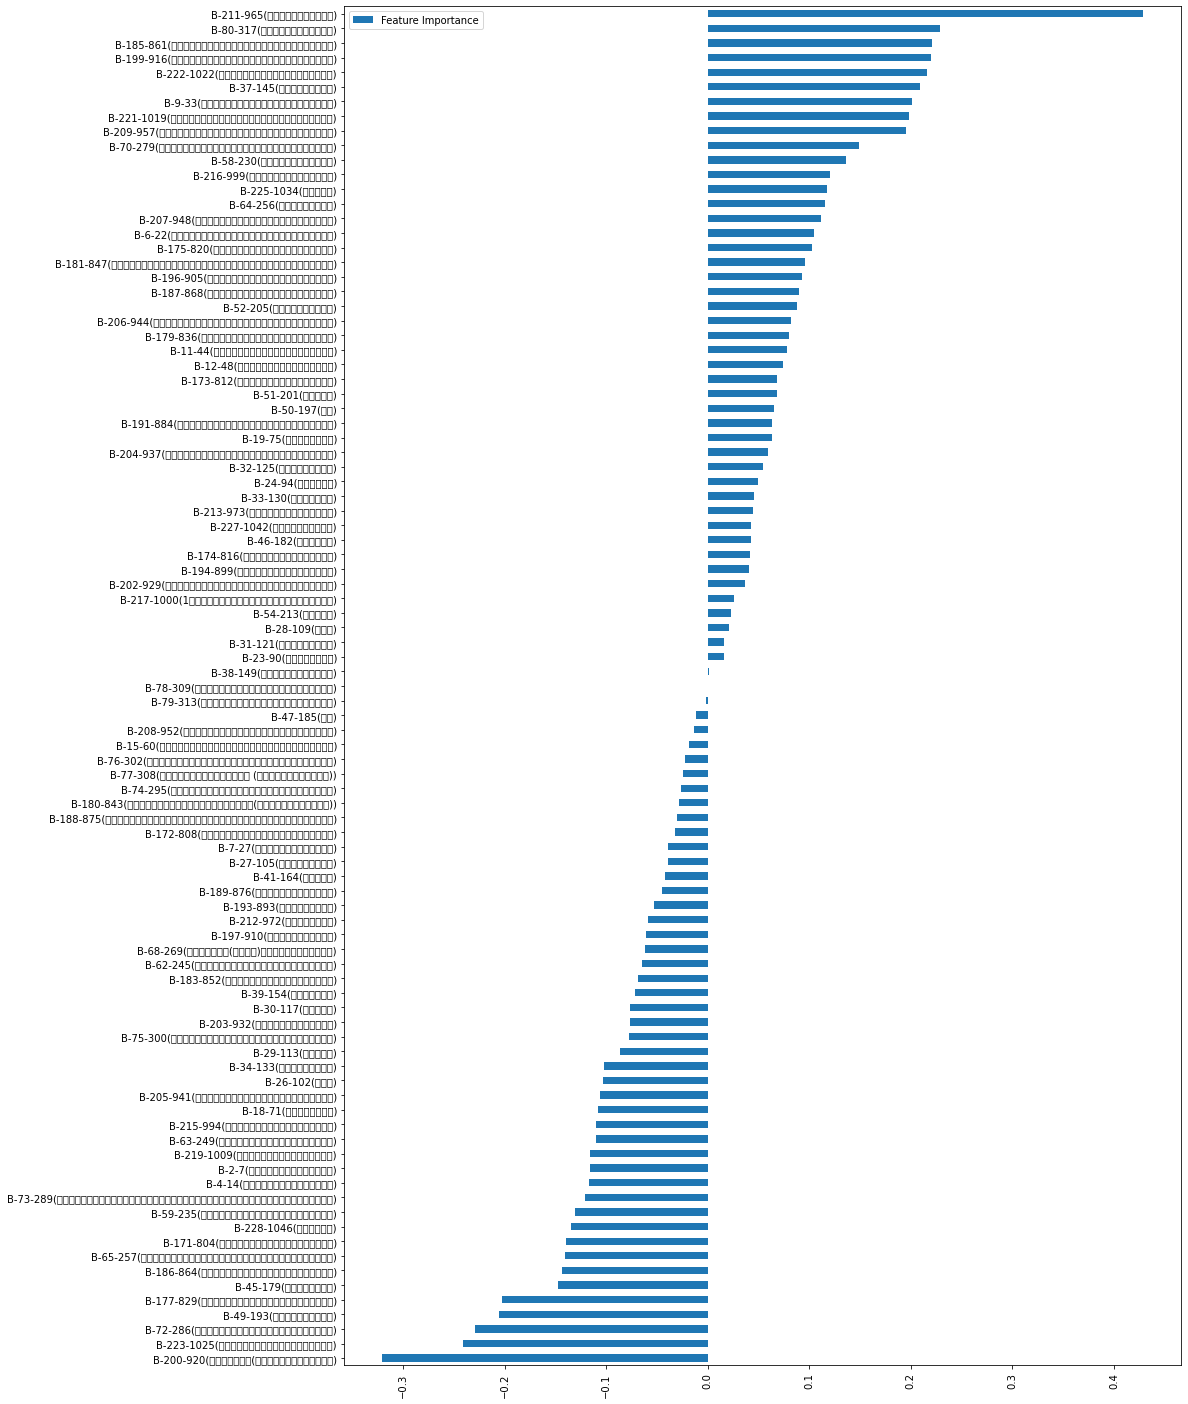

In [24]:
########## check feature importance via Lasso ##########
from sklearn.linear_model import Lasso
import  matplotlib.pyplot as plt

lasso=Lasso(alpha=0.001) # L1正则化如果太强系数容易变0变少，所以设置0.001
lasso.fit(new_data[:, 0:-1], new_data[:, -1])

FI_lasso = pd.DataFrame({'Feature Importance':lasso.coef_}, index=new_feature_names[0:-1])
print('feature importance via Lasso')
# rank feature importance
print(FI_lasso.sort_values('Feature Importance',ascending=False))
# visualize feature importance
FI_lasso[FI_lasso['Feature Importance']!=0].sort_values('Feature Importance').plot(kind='barh',figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

feature importance via ridge
                                                    Feature Importance
B-211-965(転職・退職を考えている)                                        0.313482
B-222-1022(勤務日の平均的な就寝時刻を教えて下さい)                               0.169842
B-37-145(体のふしぶしが痛む)                                           0.165004
B-80-317(自分の仕事に誇りを感じる)                                        0.157694
B-185-861(仕事におけるルールや判断基準が会社として整備されている)                        0.154867
B-9-33(自分で仕事の順番・やり方を決めることができる)                                0.153636
B-199-916(会社の経営指針（理念・ビジョン・行動指針など）に満足だ)                        0.146863
B-221-1019(仕事に忙殺され、自分の自由に使える時間が十分に取れない)                       0.146387
B-209-957(入社前の期待と入社後の現実でどの程度ギャップがありますか？)                      0.144600
B-213-973(今後もこの会社で働き続けたい)                                     0.120269
B-70-279(職場や仕事で変化があるときには、従業員の意見が聞かれている)                       0.111207
B-216-999(毎日の通勤でストレスを感じる)                                     0.101840
B-64-256(職を失う恐れがある)                             

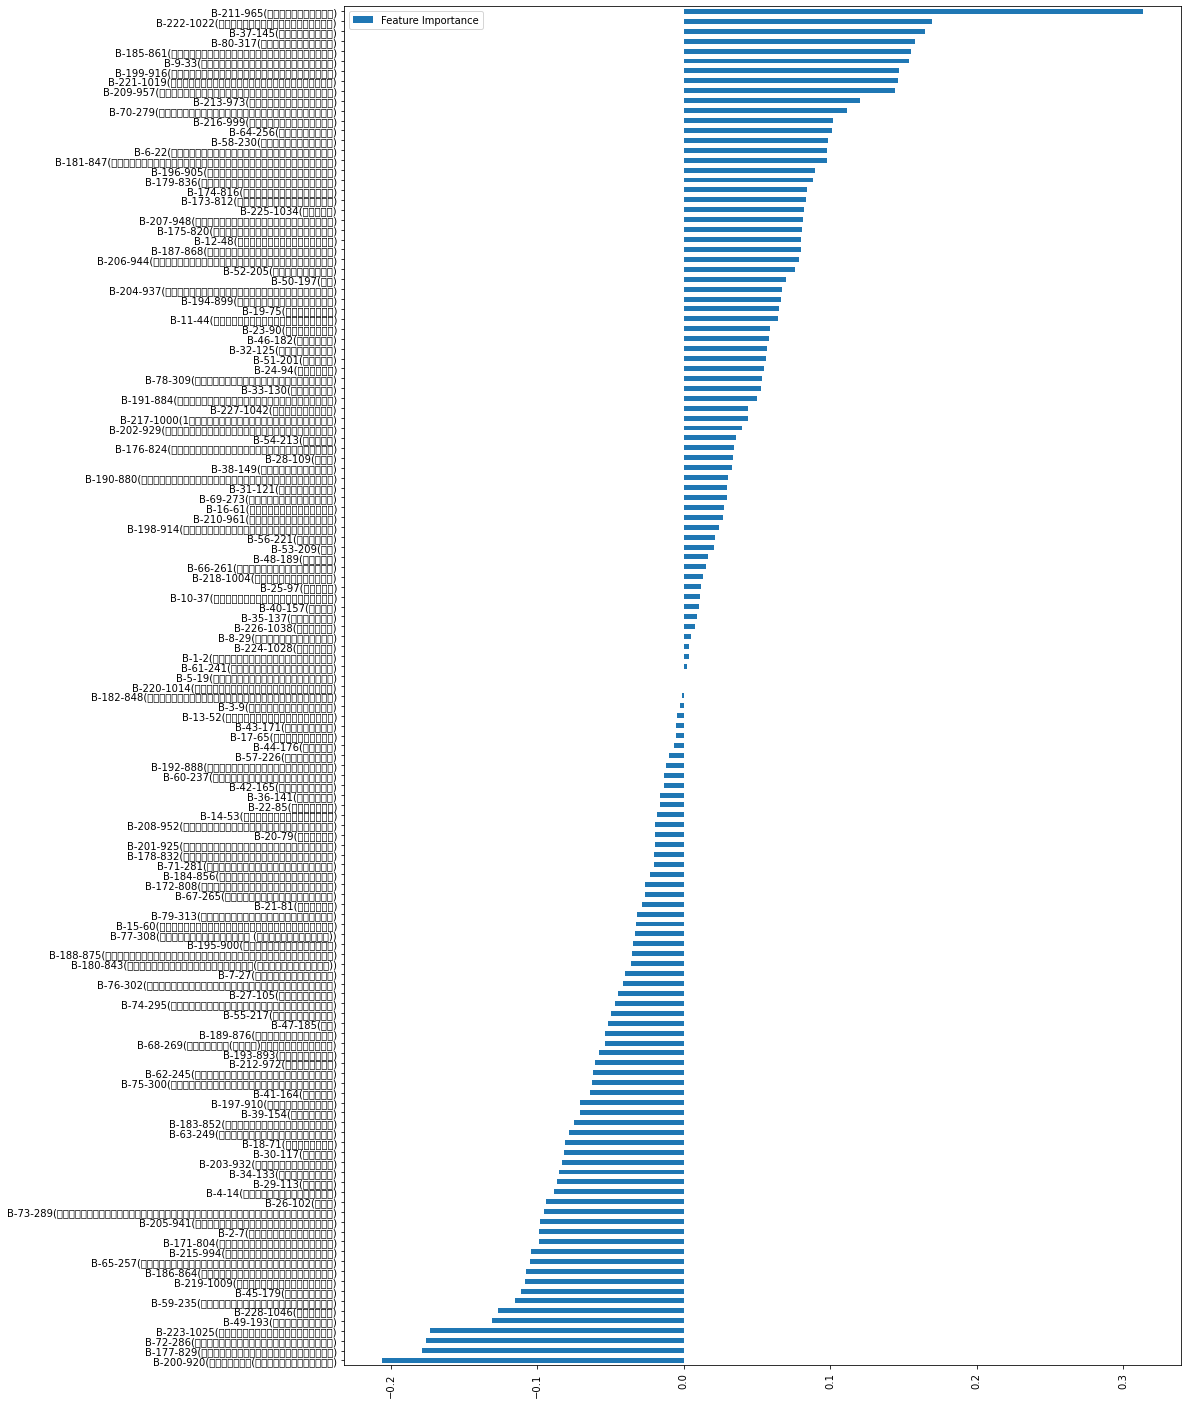

In [25]:
########## check feature importance via ridge ##########
from sklearn.linear_model import Ridge

ridge=Ridge(alpha=10)
ridge.fit(new_data[:, 0:-1], new_data[:, -1])

FI_ridge = pd.DataFrame({'Feature Importance':ridge.coef_}, index=new_feature_names[0:-1])
print('feature importance via ridge')
# rank feature importance
print(FI_ridge.sort_values('Feature Importance',ascending=False))
# visualize feature importance
FI_ridge[FI_ridge['Feature Importance']!=0].sort_values('Feature Importance').plot(kind='barh',figsize=(15,25))
plt.xticks(rotation=90)
plt.show()